In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import  DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Import model

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.CIFAR10(root='../Data',train=True,download=True,transform =  transform)


Extracting ../Data/cifar-10-python.tar.gz to ../Data


In [6]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data = datasets.CIFAR10(root='../Data',train=False,download=True,transform =  transform)

Files already downloaded and verified


In [8]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
train_data[0][0].shape

torch.Size([3, 32, 32])

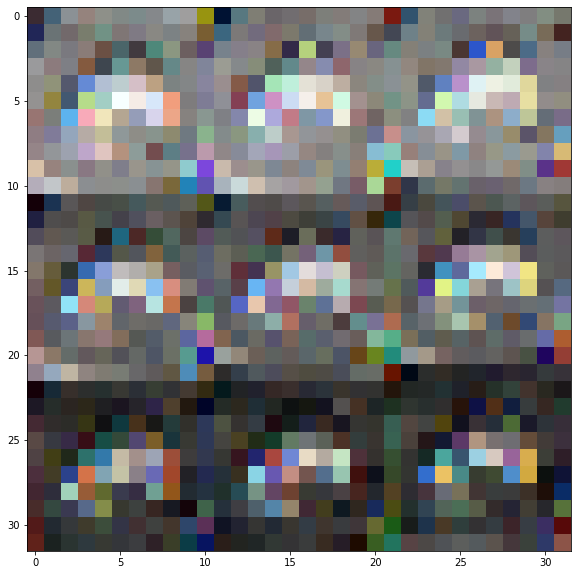

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(train_data[0][0].reshape(32,32,3))

In [13]:
image,label = train_data[0]
print('Shape:', image.shape,'\nLabel:',label)

Shape: torch.Size([3, 32, 32]) 
Label: 6


In [17]:
torch.manual_seed(101)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=50,shuffle=True)

Labels:  [   9    5    2    3    0    5    9    5    1    6]


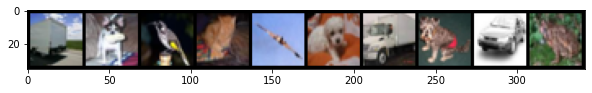

In [18]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [20]:
torch.manual_seed(101)
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [22]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 1.97440410  accuracy:  21.517%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 1.20970535  accuracy:  26.975%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 1.86880136  accuracy:  30.378%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 1.14751065  accuracy:  33.046%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 1.22219241  accuracy:  35.290%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 1.65189576  accuracy:  37.025%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.97039348  accuracy:  38.474%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 1.67991674  accuracy:  39.638%
epoch:  1  batch:  600 [  6000/60000]  loss: 1.04109550  accuracy:  49.783%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 1.26134312  accuracy:  50.575%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 1.50999808  accuracy:  51.200%
epoch:  1  batch: 2400 [ 24000/60000]  loss: 1.95886731  accuracy:  51.717%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 2.04693890  accuracy:  52.067%
epoch:  1  b

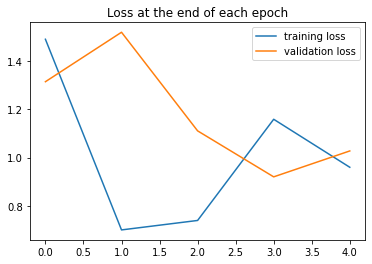

In [25]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

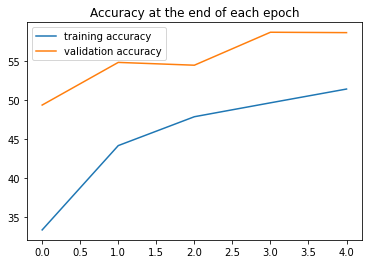

In [26]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [27]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4932), tensor(5478), tensor(5442), tensor(5864), tensor(5859)]

Test accuracy: 58.590%


In [28]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [29]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 5859/10000 =  58.590%


In [30]:
y_eval = model.forward(X_test)

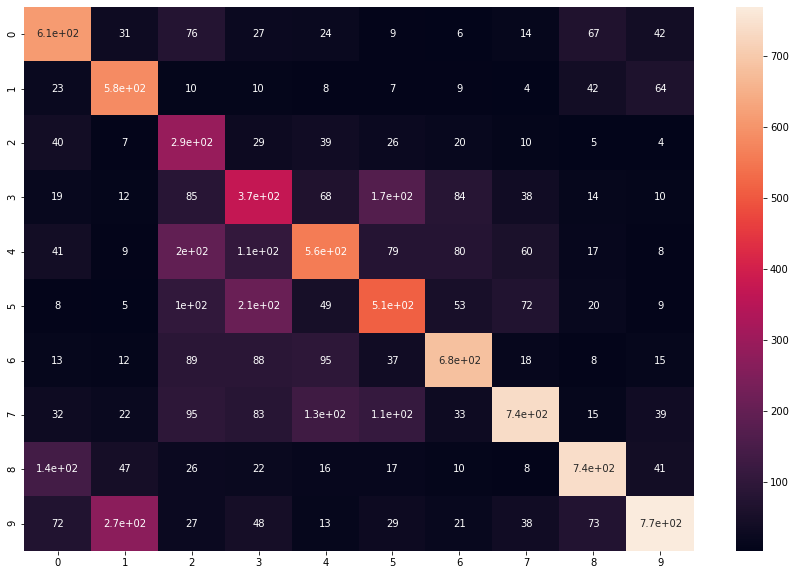

In [31]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_eval.argmax(1),y_test),annot=True)